# MadMiner tutorial 2: SALLY, Fisher information, and ensemble methods (parton level)

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In the first tutorial you saw how to set up a process with MadMiner, generate events and turn them into training samples, and construct likelihood ratio estimators from them. Here we introduce some alternative steps which will lead us to an estimator for the score at a reference point (SALLY) and the expected Fisher information. Along the way, we'll introduce some powerful ensemble methods.

If you're not familiar with SALLY, please have a look at ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013)
or, for more details, ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020). For the Fisher information part, see the original publication ["Better Higgs Measurements Through Information Geometry"](https://arxiv.org/abs/1612.05261) or a more detailed, pedagogical introduction in Chapter 4 of ["New Ideas for Effective Higgs Measurements"](https://inspirehep.net/record/1624219).

## Preparations

Make sure you've run the first tutorial before executing this notebook!

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.sampling import SampleAugmenter, constant_benchmark_theta
from madminer.ml import MLForge, EnsembleForge
from madminer.fisherinformation import FisherInformation
from madminer.plotting import plot_fisher_information_contours_2d


MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.DEBUG
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. to 5.: see tutorial 1.

We assume that you have run steps 1 through 5 of the first tutorial, and thus have a MadMiner file with observables and event weights ready to go!

## 6. Make (unweighted) training and test samples with augmented data

Again, the next step is handled by the MadMiner class `SampleAugmenter`.

In [3]:
sa = SampleAugmenter('data/madminer_example_shuffled.h5')

11:28 madminer.sampling    INFO    Loading data from data/madminer_example_shuffled.h5
11:28 madminer.sampling    INFO    Found 2 parameters
11:28 madminer.sampling    DEBUG      CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-10.0, 10.0))
11:28 madminer.sampling    DEBUG      CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-10.0, 1.0))
11:28 madminer.sampling    INFO    Did not find nuisance parameters
11:28 madminer.sampling    INFO    Found 6 benchmarks, of which 6 physical
11:28 madminer.sampling    DEBUG      sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
11:28 madminer.sampling    DEBUG      w: CWL2 = 10.00, CPWL2 = 0.00e+00
11:28 madminer.sampling    DEBUG      morphing_basis_vector_2: CWL2 = -2.43e+00, CPWL2 = -9.92e+00
11:28 madminer.sampling    DEBUG      morphing_basis_vector_3: CWL2 = -8.02e+00, CPWL2 = -5.62e+00
11:28 madminer.sampling    DEBUG      morphing_basis_vector_4: CWL2 = -7.13e+00, CPWL2 = -1.36e+00
11:28 madminer.sampling    DEBUG      morph

The relevant `SampleAugmenter` function for local score estimators is `extract_samples_train_local()`. As before, for the argument `theta` you can use the helper functions `constant_benchmark_theta()`, `multiple_benchmark_thetas()`, `constant_morphing_theta()`, `multiple_morphing_thetas()`, and `random_morphing_thetas()`.

In [4]:
x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='train'
)

11:28 madminer.sampling    INFO    Extracting training sample for local score regression. Sampling and score evaluation according to (u'benchmark', u'sm')
11:28 madminer.sampling    DEBUG   Starting sample extraction
11:28 madminer.sampling    DEBUG   Augmented data requested:
11:28 madminer.sampling    DEBUG     (u'score', 0)
11:28 madminer.sampling    DEBUG   Benchmark cross sections [pb]: [3.73110584e-05 2.41485478e-04 5.57774798e-04 4.94442997e-04
 2.84443497e-04 2.06884202e-04]
11:28 madminer.sampling    DEBUG   Drawing 100000 events for the following thetas:
11:28 madminer.sampling    DEBUG     theta 0 = [0. 0.] (sampling)
11:28 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 0.9999999999999912
11:28 madminer.sampling    INFO    Effective number of samples: 3269.0000000001205


## 7a. Train one network to estimate score and Fisher information

It's now time to build a neural network. Only this time, instead of the likelihood ratio itself, we will estimate the gradient of the log likelihood with respect to the theory parameters -- the score. To be precise, the output of the neural network is an estimate of the score at some reference parameter point, for instance the Standard Model. A neural network that estimates this "local" score can be used to calculate the Fisher information at that point. The estimated score can also be used as a machine learning version of Optimal Observables, and likelihoods can be estimated based on density estimation in the estimated score space. This method for likelihood ratio estimation is called SALLY, and there is a closely related version called SALLINO. Both are explained in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020).

Again, the central object for this is the `madminer.ml.MLForge` class:

In [5]:
forge = MLForge()

### Training

In [6]:
forge.train(
    method='sally',
    x_filename='data/samples/x_train.npy',
    t_xz0_filename='data/samples/t_xz_train.npy',
    verbose="all",
)

forge.save('models/sally')

11:28 madminer.ml          INFO    Starting training
11:28 madminer.ml          INFO      Method:                 sally
11:28 madminer.ml          INFO      Training data:          x at data/samples/x_train.npy
11:28 madminer.ml          INFO                              t_xz (theta0) at data/samples/t_xz_train.npy
11:28 madminer.ml          INFO      Features:               all
11:28 madminer.ml          INFO      Method:                 sally
11:28 madminer.ml          INFO      Hidden layers:          (100, 100)
11:28 madminer.ml          INFO      Activation function:    tanh
11:28 madminer.ml          INFO      Batch size:             128
11:28 madminer.ml          INFO      Optimizer:              amsgrad
11:28 madminer.ml          INFO      Epochs:                 50
11:28 madminer.ml          INFO      Learning rate:          0.001 initially, decaying to 0.0001
11:28 madminer.ml          INFO      Validation split:       None
11:28 madminer.ml          INFO      Early stopping:

11:29 madminer.utils.ml.tr DEBUG   Training epoch 29 / 50
11:29 madminer.utils.ml.tr DEBUG   Learning rate: 0.000268269579528
11:30 madminer.utils.ml.tr INFO      Epoch  29: train loss 0.078546 (mse_score: 0.078546)
11:30 madminer.utils.ml.tr DEBUG   Training epoch 30 / 50
11:30 madminer.utils.ml.tr DEBUG   Learning rate: 0.00025595479227
11:30 madminer.utils.ml.tr INFO      Epoch  30: train loss 0.078334 (mse_score: 0.078334)
11:30 madminer.utils.ml.tr DEBUG   Training epoch 31 / 50
11:30 madminer.utils.ml.tr DEBUG   Learning rate: 0.000244205309455
11:30 madminer.utils.ml.tr INFO      Epoch  31: train loss 0.078212 (mse_score: 0.078212)
11:30 madminer.utils.ml.tr DEBUG   Training epoch 32 / 50
11:30 madminer.utils.ml.tr DEBUG   Learning rate: 0.000232995181052
11:30 madminer.utils.ml.tr INFO      Epoch  32: train loss 0.077877 (mse_score: 0.077877)
11:30 madminer.utils.ml.tr DEBUG   Training epoch 33 / 50
11:30 madminer.utils.ml.tr DEBUG   Learning rate: 0.000222299648253
11:30 madmi

### Evaluation

Let's evaluate the SM score on the test data

In [7]:
forge.load('models/sally')

t_hat = forge.evaluate(
    x='data/samples/x_test.npy'
)

11:30 madminer.ml          DEBUG   Loading settings from models/sally_settings.json
11:30 madminer.ml          DEBUG     Found method sally, 2 observables, 2 parameters, (100, 100) hidden layers, tanh activation function, features None
11:30 madminer.ml          DEBUG     Found input scaling information: means [ 9.96285456e+01 -2.12426828e-02], stds [58.04764699  2.02795118]
11:30 madminer.ml          DEBUG   Loading state dictionary from models/sally_state_dict.pt
11:30 madminer.ml          DEBUG   Loading evaluation data
11:30 madminer.ml          DEBUG   Starting score evaluation


Let's have a look at the estimated score and how it is related to the observables:

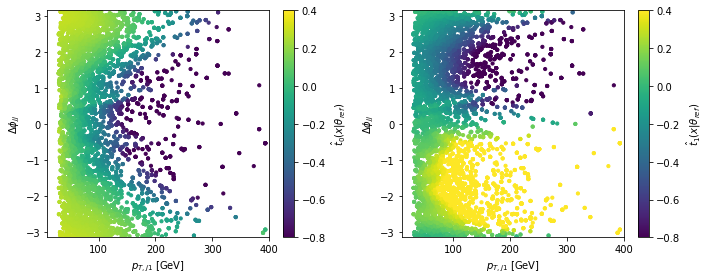

In [8]:
x = np.load('data/samples/x_test.npy')

fig = plt.figure(figsize=(10,4))

for i in range(2):
    
    ax = plt.subplot(1,2,i+1)

    sc = plt.scatter(x[::10,0], x[::10,1], c=t_hat[::10,i], s=10., cmap='viridis', vmin=-0.8, vmax=0.4)
    cbar = plt.colorbar(sc)

    cbar.set_label(r'$\hat{t}_' + str(i) + r'(x | \theta_{ref})$')
    plt.xlabel(r'$p_{T,j1}$ [GeV]')
    plt.ylabel(r'$\Delta \phi_{jj}$')
    plt.xlim(10.,400.)
    plt.ylim(-3.15,3.15)
    
plt.tight_layout()
plt.show()


### Fisher information

In addition, we can use SALLY estimators to estimate the expected Fisher information.

In [9]:
fisher = FisherInformation('data/madminer_example_shuffled.h5')

11:30 madminer.fisherinfor INFO    Loading data from data/madminer_example_shuffled.h5
11:30 madminer.fisherinfor INFO    Found 2 parameters
11:30 madminer.fisherinfor DEBUG      CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-10.0, 10.0))
11:30 madminer.fisherinfor DEBUG      CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-10.0, 1.0))
11:30 madminer.fisherinfor WARNING Did not find nuisance parameters!
11:30 madminer.fisherinfor INFO    Found 6 benchmarks, of which 6 physical
11:30 madminer.fisherinfor DEBUG      sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
11:30 madminer.fisherinfor DEBUG      w: CWL2 = 10.00, CPWL2 = 0.00e+00
11:30 madminer.fisherinfor DEBUG      morphing_basis_vector_2: CWL2 = -2.43e+00, CPWL2 = -9.92e+00
11:30 madminer.fisherinfor DEBUG      morphing_basis_vector_3: CWL2 = -8.02e+00, CPWL2 = -5.62e+00
11:30 madminer.fisherinfor DEBUG      morphing_basis_vector_4: CWL2 = -7.13e+00, CPWL2 = -1.36e+00
11:30 madminer.fisherinfor DEBUG      morp

In [10]:
fisher_information, _ = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/sally',
    unweighted_x_sample_file='data/samples/x_test.npy',
    luminosity=3000000.
)

print('Kinematic Fisher information after 3000 ifb:\n{}'.format(fisher_information))

11:30 madminer.ml          DEBUG   Loading settings from models/sally_settings.json
11:30 madminer.ml          DEBUG     Found method sally, 2 observables, 2 parameters, (100, 100) hidden layers, tanh activation function, features None
11:30 madminer.ml          DEBUG     Found input scaling information: means [ 9.96285456e+01 -2.12426828e-02], stds [58.04764699  2.02795118]
11:30 madminer.ml          DEBUG   Loading state dictionary from models/sally_state_dict.pt
11:30 madminer.fisherinfor DEBUG   Found 2 parameters in SALLY model, matching 2 physical parameters in MadMiner file
11:30 madminer.fisherinfor DEBUG   Not including nuisance parameters
11:30 madminer.fisherinfor DEBUG   Calculating total cross section for theta = [0.0, 0.0]
11:30 madminer.fisherinfor DEBUG   Benchmarks xsecs [pb]: [7.46107032e-05 5.86533533e-04 1.07770996e-03 1.03561294e-03
 6.22544813e-04 4.92556407e-04]
11:30 madminer.fisherinfor DEBUG   Theta matrix: [1. 0. 0. 0. 0. 0.]
11:30 madminer.fisherinfor DEBUG 

Kinematic Fisher information after 3000 ifb:
[[67.94338885 14.73859724]
 [14.73859724 70.19613927]]


We can visualize the Fisher information with contours:

/Users/johannbrehmer/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'label'
  s)
/Users/johannbrehmer/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


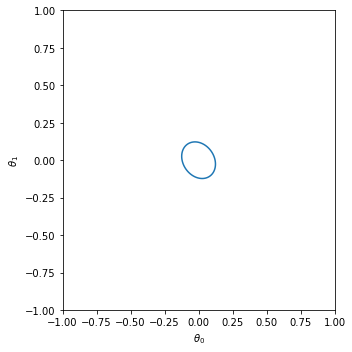

In [11]:
_ = plot_fisher_information_contours_2d(
    [fisher_information],
    xrange=(-1,1),
    yrange=(-1,1)
)

## 7b. Ensemble methods

Instead of using a single neural network to estimate the likelihood ratio, score, or Fisher information, we can use an ensemble of such estimators. That provides us with a more reliable mean prediction as well as a measure of the uncertainty. The class `madminer.ml.EnsembleForge` automates this process. Currently, it only supports SALLY estimators:

In [12]:
ensemble = EnsembleForge(estimators=5)

### Training

The `EnsembleForge` object has very similar functions as `MLForge`. In particular, we can train all estimators simultaneously with `train_all()` and save the ensemble to files:

In [13]:
ensemble.train_all(
    method='sally',
    x_filename='data/samples/x_train.npy',
    t_xz0_filename='data/samples/t_xz_train.npy',
    n_epochs=20,
    batch_size=256,
    validation_split=0.3
)

ensemble.save('models/sally_ensemble')

11:31 madminer.ml          INFO    Training 5 estimators in ensemble
11:31 madminer.ml          INFO    Training estimator 1 / 5 in ensemble
11:31 madminer.ml          INFO    Starting training
11:31 madminer.ml          INFO      Method:                 sally
11:31 madminer.ml          INFO      Training data:          x at data/samples/x_train.npy
11:31 madminer.ml          INFO                              t_xz (theta0) at data/samples/t_xz_train.npy
11:31 madminer.ml          INFO      Features:               all
11:31 madminer.ml          INFO      Method:                 sally
11:31 madminer.ml          INFO      Hidden layers:          (100, 100)
11:31 madminer.ml          INFO      Activation function:    tanh
11:31 madminer.ml          INFO      Batch size:             256
11:31 madminer.ml          INFO      Optimizer:              amsgrad
11:31 madminer.ml          INFO      Epochs:                 20
11:31 madminer.ml          INFO      Learning rate:          0.001 initial

11:31 madminer.utils.ml.tr INFO      Epoch  20: train loss 0.091176 (mse_score: 0.091176)
11:31 madminer.utils.ml.tr INFO                val. loss  0.095995 (mse_score: 0.095995)
11:31 madminer.utils.ml.tr INFO    Early stopping did not improve performance
11:31 madminer.utils.ml.tr DEBUG   Training finished
11:31 madminer.ml          INFO    Training estimator 2 / 5 in ensemble
11:31 madminer.ml          INFO    Starting training
11:31 madminer.ml          INFO      Method:                 sally
11:31 madminer.ml          INFO      Training data:          x at data/samples/x_train.npy
11:31 madminer.ml          INFO                              t_xz (theta0) at data/samples/t_xz_train.npy
11:31 madminer.ml          INFO      Features:               all
11:31 madminer.ml          INFO      Method:                 sally
11:31 madminer.ml          INFO      Hidden layers:          (100, 100)
11:31 madminer.ml          INFO      Activation function:    tanh
11:31 madminer.ml          INFO

11:32 madminer.utils.ml.tr INFO                val. loss  0.089948 (mse_score: 0.089948)
11:32 madminer.utils.ml.tr DEBUG   Training epoch 20 / 20
11:32 madminer.utils.ml.tr DEBUG   Learning rate: 0.0001
11:32 madminer.utils.ml.tr INFO      Epoch  20: train loss 0.093232 (mse_score: 0.093232)
11:32 madminer.utils.ml.tr INFO                val. loss  0.091959 (mse_score: 0.091959)
11:32 madminer.utils.ml.tr INFO    Early stopping did not improve performance
11:32 madminer.utils.ml.tr DEBUG   Training finished
11:32 madminer.ml          INFO    Training estimator 3 / 5 in ensemble
11:32 madminer.ml          INFO    Starting training
11:32 madminer.ml          INFO      Method:                 sally
11:32 madminer.ml          INFO      Training data:          x at data/samples/x_train.npy
11:32 madminer.ml          INFO                              t_xz (theta0) at data/samples/t_xz_train.npy
11:32 madminer.ml          INFO      Features:               all
11:32 madminer.ml          INFO 

11:33 madminer.utils.ml.tr DEBUG   Training epoch 19 / 20
11:33 madminer.utils.ml.tr DEBUG   Learning rate: 0.000112883789168
11:33 madminer.utils.ml.tr INFO      Epoch  19: train loss 0.092916 (mse_score: 0.092916)
11:33 madminer.utils.ml.tr INFO                val. loss  0.097971 (mse_score: 0.097971)
11:33 madminer.utils.ml.tr DEBUG   Training epoch 20 / 20
11:33 madminer.utils.ml.tr DEBUG   Learning rate: 0.0001
11:33 madminer.utils.ml.tr INFO      Epoch  20: train loss 0.092342 (mse_score: 0.092342)
11:33 madminer.utils.ml.tr INFO                val. loss  0.095757 (mse_score: 0.095757)
11:33 madminer.utils.ml.tr INFO    Early stopping did not improve performance
11:33 madminer.utils.ml.tr DEBUG   Training finished
11:33 madminer.ml          INFO    Training estimator 4 / 5 in ensemble
11:33 madminer.ml          INFO    Starting training
11:33 madminer.ml          INFO      Method:                 sally
11:33 madminer.ml          INFO      Training data:          x at data/samples

11:34 madminer.utils.ml.tr DEBUG   Learning rate: 0.00012742749857
11:34 madminer.utils.ml.tr INFO      Epoch  18: train loss 0.094698 (mse_score: 0.094698)
11:34 madminer.utils.ml.tr INFO                val. loss  0.089667 (mse_score: 0.089667)
11:34 madminer.utils.ml.tr DEBUG   Training epoch 19 / 20
11:34 madminer.utils.ml.tr DEBUG   Learning rate: 0.000112883789168
11:34 madminer.utils.ml.tr INFO      Epoch  19: train loss 0.094403 (mse_score: 0.094403)
11:34 madminer.utils.ml.tr INFO                val. loss  0.089822 (mse_score: 0.089822)
11:34 madminer.utils.ml.tr DEBUG   Training epoch 20 / 20
11:34 madminer.utils.ml.tr DEBUG   Learning rate: 0.0001
11:34 madminer.utils.ml.tr INFO      Epoch  20: train loss 0.093936 (mse_score: 0.093936)
11:34 madminer.utils.ml.tr INFO                val. loss  0.090692 (mse_score: 0.090692)
11:34 madminer.utils.ml.tr INFO    Early stopping did not improve performance
11:34 madminer.utils.ml.tr DEBUG   Training finished
11:34 madminer.ml       

11:34 madminer.utils.ml.tr INFO      Epoch  17: train loss 0.093454 (mse_score: 0.093454)
11:34 madminer.utils.ml.tr INFO                val. loss  0.090986 (mse_score: 0.090986)
11:34 madminer.utils.ml.tr DEBUG   Training epoch 18 / 20
11:34 madminer.utils.ml.tr DEBUG   Learning rate: 0.00012742749857
11:34 madminer.utils.ml.tr INFO      Epoch  18: train loss 0.092941 (mse_score: 0.092941)
11:34 madminer.utils.ml.tr INFO                val. loss  0.091047 (mse_score: 0.091047)
11:34 madminer.utils.ml.tr DEBUG   Training epoch 19 / 20
11:34 madminer.utils.ml.tr DEBUG   Learning rate: 0.000112883789168
11:34 madminer.utils.ml.tr INFO      Epoch  19: train loss 0.093075 (mse_score: 0.093075)
11:34 madminer.utils.ml.tr INFO                val. loss  0.090865 (mse_score: 0.090865)
11:34 madminer.utils.ml.tr DEBUG   Training epoch 20 / 20
11:34 madminer.utils.ml.tr DEBUG   Learning rate: 0.0001
11:34 madminer.utils.ml.tr INFO      Epoch  20: train loss 0.092832 (mse_score: 0.092832)
11:34 m

### Evaluation

We can evaluate the ensemble similarly to the individual networks. Let's stick to the estimation of the Fisher information. There are two different ways to take the ensemble average:

- `mode='information'`: We can calculate the Fisher information for each estimator in the ensemble, and then take the mean and the covariance over the ensemble. This has the advantage that it provides a direct measure of the uncertainty of the prediction.
- `mode='score'`: We can calculate the score for each event and estimator, take the ensemble mean for the score of each event, and then calculate the Fisher information based on the mean scores. This is expected to be more precise (since the score estimates will be more precise, and the nonlinearity in the Fisher info calculation amplifies any error in the score estimation). But calculating the covariance in this approach is computationally not feasible, so there will be no error bands.

By default, MadMiner uses the 'score' mode. Here we will use the 'information' mode just to show the nice uncertainty bands we get.

In [14]:
fisher = FisherInformation('data/madminer_example_shuffled.h5')

fisher_information_mean, fisher_information_covariance = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/sally_ensemble',
    luminosity=3000000.,
    mode='information'
)

11:34 madminer.fisherinfor INFO    Loading data from data/madminer_example_shuffled.h5
11:34 madminer.fisherinfor INFO    Found 2 parameters
11:34 madminer.fisherinfor DEBUG      CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-10.0, 10.0))
11:34 madminer.fisherinfor DEBUG      CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-10.0, 1.0))
11:34 madminer.fisherinfor WARNING Did not find nuisance parameters!
11:34 madminer.fisherinfor INFO    Found 6 benchmarks, of which 6 physical
11:34 madminer.fisherinfor DEBUG      sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
11:34 madminer.fisherinfor DEBUG      w: CWL2 = 10.00, CPWL2 = 0.00e+00
11:34 madminer.fisherinfor DEBUG      morphing_basis_vector_2: CWL2 = -2.43e+00, CPWL2 = -9.92e+00
11:34 madminer.fisherinfor DEBUG      morphing_basis_vector_3: CWL2 = -8.02e+00, CPWL2 = -5.62e+00
11:34 madminer.fisherinfor DEBUG      morphing_basis_vector_4: CWL2 = -7.13e+00, CPWL2 = -1.36e+00
11:34 madminer.fisherinfor DEBUG      morp

The covariance can be propagated to the Fisher distance contour plot easily:

11:34 madminer.plotting    DEBUG   Std: [[4.37209014 4.3472277  4.32243857 ... 1.90232773 1.90107404 1.89980605]
 [4.36194937 4.33711356 4.31235092 ... 1.88587054 1.88460766 1.88333099]
 [4.3518225  4.32701346 4.30227745 ... 1.86947032 1.86819875 1.8669139 ]
 ...
 [1.8669139  1.86819875 1.86947032 ... 4.30227745 4.32701346 4.3518225 ]
 [1.88333099 1.88460766 1.88587054 ... 4.31235092 4.33711356 4.36194937]
 [1.89980605 1.90107404 1.90232773 ... 4.32243857 4.3472277  4.37209014]]


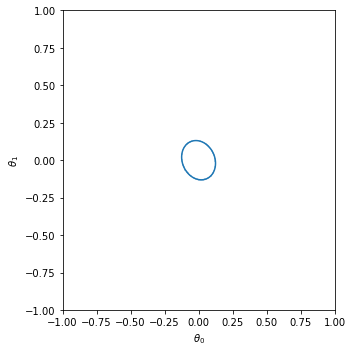

In [15]:
_ = plot_fisher_information_contours_2d(
    [fisher_information_mean],
    [fisher_information_covariance],
    xrange=(-1,1),
    yrange=(-1,1)
)

That's the end of the second part of this tutorial. If you have questions, please have a look at the papers, the module documentation, or drop us an email.